In [2]:
#gets all this setup
import time
start_time = time.time()
from transformers import BertTokenizer
from pathlib import Path
import torch

from box import Box
import pandas as pd
import collections
import os
from tqdm import tqdm, trange
import sys
import random
import numpy as np
# import apex
from sklearn.model_selection import train_test_split

import datetime

from fast_bert.modeling import BertForMultiLabelSequenceClassification
from fast_bert.data_cls import BertDataBunch, InputExample, InputFeatures, MultiLabelTextProcessor, convert_examples_to_features
from fast_bert.learner_cls import BertLearner
# from fast_bert.metrics import accuracy_multilabel, accuracy_thresh, fbeta, roc_auc, accuracy
from fast_bert.metrics import *

torch.cuda.empty_cache()

pd.set_option('display.max_colwidth', -1)
run_start_time = datetime.datetime.today().strftime('%Y-%m-%d_%H-%M-%S')

# LOG_PATH=Path('/scratch/da2734/twitter/sana/log/')
# DATA_PATH=Path('/scratch/da2734/twitter/sana/data')
# LABEL_PATH=Path('/scratch/da2734/twitter/sana/data/')
# OUTPUT_PATH=Path('/scratch/da2734/twitter/sana/output/')
LOG_PATH=Path('/scratch/da2734/twitter/mturk_mar6/log/')
DATA_PATH=Path('/scratch/da2734/twitter/mturk_mar6/data')
LABEL_PATH=Path('/scratch/da2734/twitter/mturk_mar6/data/')
OUTPUT_PATH=Path('/scratch/da2734/twitter/mturk_mar6/output_100')
FINETUNED_PATH = None

args = Box({
    "run_text": "multilabel toxic comments with freezable layers",
    "train_size": -1,
    "val_size": -1,
    "log_path": LOG_PATH,
    "full_data_dir": DATA_PATH,
    "data_dir": DATA_PATH,
    "task_name": "labor_market_classification",
    "no_cuda": False,
#     "bert_model": BERT_PRETRAINED_PATH,
    "output_dir": OUTPUT_PATH,
    "max_seq_length": 512,
    "do_train": True,
    "do_eval": True,
    "do_lower_case": True,
    "train_batch_size": 8,
    "eval_batch_size": 200,
    "learning_rate": 5e-5,
    "num_train_epochs": 6,
    "warmup_proportion": 0.0,
    "no_cuda": False,
    "local_rank": -1,
    "seed": 42,
    "gradient_accumulation_steps": 1,
    "optimize_on_cpu": False,
    "fp16": False,
    "fp16_opt_level": "O1",
    "weight_decay": 0.0,
    "adam_epsilon": 1e-8,
    "max_grad_norm": 1.0,
    "max_steps": -1,
    "warmup_steps": 500,
    "logging_steps": 50,
    "eval_all_checkpoints": True,
    "overwrite_output_dir": True,
    "overwrite_cache": False,
    "seed": 42,
    "loss_scale": 128,
    "task_name": 'intent',
    "model_name": 'bert-base-uncased',
    "model_type": 'bert'
})

import logging

logfile = str(LOG_PATH/'log-{}-{}.txt'.format(run_start_time, args["run_text"]))

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
    datefmt='%m/%d/%Y %H:%M:%S',
    handlers=[
        logging.FileHandler(logfile),
        logging.StreamHandler(sys.stdout)
    ])

logger = logging.getLogger()

# logger.info(args)

device = torch.device('cpu')
if torch.cuda.device_count() > 1:
    args.multi_gpu = True
else:
    args.multi_gpu = False

label_cols = ["job_loss","is_unemployed","job_search","is_hired","job_offer"]

# databunch defined here https://github.com/kaushaltrivedi/fast-bert/blob/master/fast_bert/data_cls.py
databunch = BertDataBunch(
                        args['data_dir'], 
                        LABEL_PATH, 
                        args.model_name, 
                        train_file='train.csv', 
                        val_file='val.csv',
                        # test_data='test.csv',
                        text_col="text", #this is the name of the column in the train file that containts the tweet text
                        label_col=label_cols,
                        batch_size_per_gpu=args['train_batch_size'], 
                        max_seq_length=args['max_seq_length'], 
                        multi_gpu=args.multi_gpu, 
                        multi_label=True, 
                        model_type=args.model_type)

num_labels = len(databunch.labels)
print('num_labels', num_labels)

# print('__Python VERSION:', sys.version)
# print('__pyTorch VERSION:', torch.__version__)
# print('__CUDA VERSION')
# print('__CUDNN VERSION:', torch.backends.cudnn.version())
# print('__Number CUDA Devices:', torch.cuda.device_count())
# print('__Devices')
# print('Active CUDA Device: GPU', torch.cuda.current_device())

# print ('Available devices ', torch.cuda.device_count())
# # print ('Current cuda device ', torch.cuda.current_device)

# metrics defined: https://github.com/kaushaltrivedi/fast-bert/blob/d89e2aa01d948d6d3cdea7ad106bf5792fea7dfa/fast_bert/metrics.py
metrics = []
metrics.append({'name': 'accuracy_thresh', 'function': accuracy_thresh})
metrics.append({'name': 'roc_auc', 'function': roc_auc})
metrics.append({'name': 'roc_auc_save_to_plot', 'function': roc_auc_save_to_plot})
metrics.append({'name': 'fbeta', 'function': fbeta})
metrics.append({'name': 'accuracy', 'function': accuracy})
metrics.append({'name': 'accuracy_multilabel', 'function': accuracy_multilabel})


learner = BertLearner.from_pretrained_model(
                                            databunch, 
                                            pretrained_path='/scratch/da2734/twitter/mturk_mar6/output_100/model_out/', 
                                            metrics=metrics, 
                                            device=device, 
                                            logger=logger, 
                                            output_dir=args.output_dir, 
                                            finetuned_wgts_path=FINETUNED_PATH, 
                                            warmup_steps=args.warmup_steps,
                                            multi_gpu=args.multi_gpu, 
                                            is_fp16=args.fp16, 
                                            multi_label=True, 
                                            logging_steps=0)

print('time taken to load all this stuff:', str(time.time() - start_time), 'seconds')



03/07/2020 20:34:03 - INFO - transformers.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/da2734/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
03/07/2020 20:34:03 - INFO - root -   Loading features from cached file /scratch/da2734/twitter/mturk_mar6/data/cache/cached_bert_train_multi_label_512_train.csv


/home/da2734/miniconda3/envs/worldbank/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


03/07/2020 20:34:03 - INFO - root -   Loading features from cached file /scratch/da2734/twitter/mturk_mar6/data/cache/cached_bert_dev_multi_label_512_val.csv
num_labels 5
03/07/2020 20:34:03 - INFO - transformers.configuration_utils -   loading configuration file /scratch/da2734/twitter/mturk_mar6/output_100/model_out/config.json
03/07/2020 20:34:03 - INFO - transformers.configuration_utils -   Model config BertConfig {
  "architectures": [
    "BertForMultiLabelSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "do_sample": false,
  "eos_token_ids": 0,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings":

In [1]:
import time
start_time = time.time()
import pyarrow.parquet as pq
from glob import glob
import os
country_code = 'US'
month = '2012-1'
path_to_data = '/scratch/spf248/twitter/data/tweets/tweets-with-identified-location'
tweets=pq.ParquetDataset(glob(os.path.join(path_to_data,                                           
                                           country_code,
                                           month,
                                           '*.parquet'))).read().to_pandas()
print('time taken to load all this stuff:', str(time.time() - start_time), 'seconds')


time taken to load all this stuff: 65.66325306892395 seconds


In [3]:
print(type(tweets))
print(tweets.shape)
tweets.head()

<class 'pandas.core.frame.DataFrame'>
(32528836, 9)


,tweet_id,created_at,text,tweet_lang,user_id,user_location,place_id,tweet_longitude,tweet_latitude
0,153626664641900545,2012-01-02 00:00:25,Yay the water show at the Bellagio is about to start,None,25776596,Milwaukee,None,None,None
1,153626794518515712,2012-01-02 00:00:56,@ChrisSanders_AZ section?,None,32157248,"Chandler, AZ",None,None,None
2,153626823803146242,2012-01-02 00:01:03,"Anne at Home 1546-1.99 Hammerhein Bath Towel Ring: Finish:Matte Pewter, Configuration:Black Bar Never forget the... http://t.co/ohFIvEM5",None,440181006,Detroit,None,None,None
3,153626836448980992,2012-01-02 00:01:06,@THAT_G0MEZ sooooooooo i got something :D,None,18427709,so cal,None,None,None
4,153626857244340225,2012-01-02 00:01:11,Going to the hotel (:,None,280956698,NY,None,None,None


In [4]:
def time_per_tweet(num_tweets):
    start_time = time.time()
#     num_tweets = 1000
    # texts = ['I just received a job offer']
    texts = tweets['text'][:num_tweets].values.tolist()
    # print(texts)
    predictions = learner.predict_batch(texts)
    # i = 3
    # print(texts[i], predictions[i])
    time_taken = time.time() - start_time
    print('total inference time:', time_taken, 'seconds')
    print('per tweet:', time_taken/num_tweets, 'seconds')
    return {'num_tweets': num_tweets, 'total': time_taken, 'pertweet': time_taken/num_tweets}

results = pd.DataFrame()
for i in range(5):
    print(1*(10**i), 'tweets running..')
    results = results.append(time_per_tweet(1*(10**i)), 
                             ignore_index=True)

print(results)

1 tweets running..
03/07/2020 20:35:52 - INFO - root -   Writing example 0 of 1
total inference time: 0.4338953495025635 seconds
per tweet: 0.4338953495025635 seconds
10 tweets running..
03/07/2020 20:35:52 - INFO - root -   Writing example 0 of 10
total inference time: 2.9416682720184326 seconds
per tweet: 0.2941668272018433 seconds
100 tweets running..
03/07/2020 20:35:55 - INFO - root -   Writing example 0 of 100
total inference time: 29.418217658996582 seconds
per tweet: 0.2941821765899658 seconds
1000 tweets running..
03/07/2020 20:36:24 - INFO - root -   Writing example 0 of 1000
total inference time: 306.78928399086 seconds
per tweet: 0.30678928399086 seconds
10000 tweets running..
03/07/2020 20:41:31 - INFO - root -   Writing example 0 of 10000
total inference time: 3087.8493390083313 seconds
per tweet: 0.3087849339008331 seconds
   num_tweets  pertweet        total
0  1.0         0.433895  0.433895   
1  10.0        0.294167  2.941668   
2  100.0       0.294182  29.418218  
3 

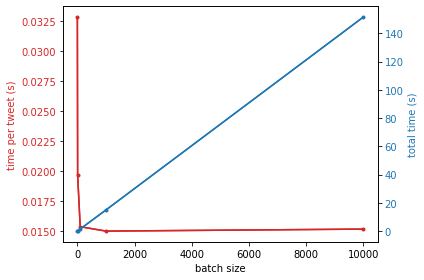

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt

# Create some mock data
# t = np.arange(0.01, 10.0, 0.01)
# data1 = np.exp(t)
# data2 = np.sin(2 * np.pi * t)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('batch size')
ax1.set_ylabel('time per tweet (s)', color=color)
ax1.plot(results["num_tweets"], results["pertweet"], color=color, marker='.')
ax1.plot(results["num_tweets"], results["pertweet"], color=color)

ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('total time (s)', color=color)  # we already handled the x-label with ax1
ax2.plot(results["num_tweets"], results["total"], color=color, marker='.')
ax2.plot(results["num_tweets"], results["total"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
def time_per_tweet(num_tweets):
    start_time = time.time()
#     num_tweets = 1000
    # texts = ['I just received a job offer']
    texts = tweets['text'][:num_tweets].values.tolist()
    # print(texts)
    predictions = learner.predict_batch(texts)
    # i = 3
    # print(texts[i], predictions[i])
    time_taken = time.time() - start_time
    print('total inference time:', time_taken, 'seconds')
    print('per tweet:', time_taken/num_tweets, 'seconds')
    return {'num_tweets': num_tweets, 'total': time_taken, 'pertweet': time_taken/num_tweets}

results = pd.DataFrame()
for i in range(6):
    print(1*(10**i), 'tweets running..')
    results = results.append(time_per_tweet(1*(10**i)), 
                             ignore_index=True)

print(results)

1 tweets running..
03/07/2020 20:16:25 - INFO - root -   Writing example 0 of 1
total inference time: 0.7384910583496094 seconds
per tweet: 0.7384910583496094 seconds
10 tweets running..
03/07/2020 20:16:26 - INFO - root -   Writing example 0 of 10
total inference time: 0.19406914710998535 seconds
per tweet: 0.019406914710998535 seconds
100 tweets running..
03/07/2020 20:16:26 - INFO - root -   Writing example 0 of 100
total inference time: 1.5122966766357422 seconds
per tweet: 0.015122966766357422 seconds
1000 tweets running..
03/07/2020 20:16:28 - INFO - root -   Writing example 0 of 1000
total inference time: 14.760337114334106 seconds
per tweet: 0.014760337114334107 seconds
10000 tweets running..
03/07/2020 20:16:42 - INFO - root -   Writing example 0 of 10000
total inference time: 149.72149348258972 seconds
per tweet: 0.014972149348258973 seconds
100000 tweets running..
03/07/2020 20:19:12 - INFO - root -   Writing example 0 of 100000
03/07/2020 20:19:17 - INFO - root -   Writing 

In [12]:
results

,num_tweets,pertweet,total
0,1.0,0.433895,0.433895
1,10.0,0.294167,2.941668
2,100.0,0.294182,29.418218
3,1000.0,0.306789,306.789284
4,10000.0,0.308785,3087.849339


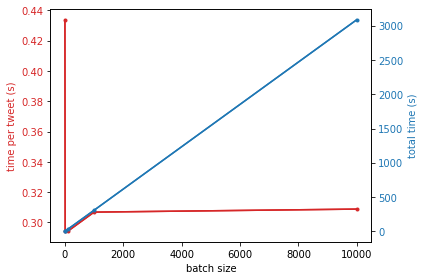

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

# Create some mock data
# t = np.arange(0.01, 10.0, 0.01)
# data1 = np.exp(t)
# data2 = np.sin(2 * np.pi * t)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('batch size')
ax1.set_ylabel('time per tweet (s)', color=color)
ax1.plot(results["num_tweets"], results["pertweet"], color=color, marker='.')
ax1.plot(results["num_tweets"], results["pertweet"], color=color)

ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('total time (s)', color=color)  # we already handled the x-label with ax1
ax2.plot(results["num_tweets"], results["total"], color=color, marker='.')
ax2.plot(results["num_tweets"], results["total"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [7]:
import pickle
start_time = time.time()
pickle.dump( tweets, open( "/scratch/da2734/twitter/tweets-with-identified-location0US-2012-1.pickle", "wb" ) )
print('time taken to pickle:', str(time.time() - start_time), 'seconds')


time taken to pickle: 43.46675968170166 seconds


In [10]:
import psutil
print(dict(psutil.virtual_memory()._asdict()))
print('memory % used:', psutil.virtual_memory()[2])
print(psutil.cpu_count(logical=False))

{'total': 201410785280, 'available': 159995785216, 'percent': 20.6, 'used': 40194478080, 'free': 96049127424, 'active': 52485287936, 'inactive': 23747649536, 'buffers': 423866368, 'cached': 64743313408, 'shared': 450867200, 'slab': 24118448128}
memory % used: 20.6
20


In [17]:
# https://github.com/kaushaltrivedi/fast-bert/blob/master/fast_bert/data_cls.py
# print(databunch.train_dl.sampler())
# print(enumerate(databunch.train_dl.dataset))
print(type(databunch.train_dl.dataset))
print(len(databunch.train_dl.dataset)) #-> 1303 tweets (i'm pretty sure)
print(len(databunch.train_dl.dataset[0])) # -> 4 objects: all_input_ids, all_input_mask, all_segment_ids, all_label_ids
print(databunch.train_dl.dataset[0][3])

<class 'torch.utils.data.dataset.TensorDataset'>
1303
4
tensor([0., 0., 0., 1., 0.])
